In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
abs_taxonomy = pd.read_csv('data/absolutetax_table.csv', index_col = [0])
abs_otu = pd.read_csv('data/absoluteotu_table.csv', index_col = [0])
abs_metadata = pd.read_csv('data/absolutemetadata.csv', index_col = [0])

rel_taxonomy = pd.read_csv('data/relativetax_table.csv', index_col = [0])
rel_otu = pd.read_csv('data/relativeotu_table.csv', index_col = [0])
rel_metadata = pd.read_csv('data/relativemetadata.csv', index_col = [0])

## Wilcoxon test on families

### Conduct Wilcoxon Test to Identify Differentially Abundant Families Between Pre- and Post-Treatment Groups

In [3]:
def analyze_taxonomic_differences(taxonomy, out_table, metadata, prevalence_threshold=0.1, relative = False):
    """
    Analyze taxonomic differences between pre and post treatment samples using Wilcoxon test.
    
    Parameters:
    -----------
    taxonomy : pandas.DataFrame
        Dataframe containing taxonomic information with Family column
    out_table : pandas.DataFrame
        OTU/ASV abundance table with samples as columns and taxa as rows
    metadata : pandas.DataFrame
        Sample metadata containing Treatment and Patient columns
    prevalence_threshold : float, optional
        Minimum prevalence threshold for including families (default: 0.1)
        
    Returns:
    --------
    pandas.DataFrame
        Results dataframe containing statistics for each family:
        - family: taxonomic family name
        - stat: Wilcoxon test statistic
        - pvalue: raw p-value
        - pval_adj: FDR-corrected p-value
    """
    # Map families to OTUs/ASVs
    family_dict = dict(zip(taxonomy.index, taxonomy.Family))
    out_table['family'] = out_table.index.map(family_dict)
    
    # Group by family
    family_df = out_table.groupby(by=['family']).sum().T
    
    # Filter by prevalence
    prevalence_df = family_df.astype(bool).astype(int).sum().sort_values()
    keep_families = prevalence_df[prevalence_df > int(len(family_df.index) * prevalence_threshold)].index.values
    family_df = family_df[keep_families]

    if relative == True:
        family_df = family_df.div(family_df.sum(axis=1), axis=0)
        family_df = np.log(family_df+1e-3)
    elif relative == False: pass
    
    # Add treatment and sample information
    treatment_dict = dict(zip(metadata.index, metadata.Treatment))
    family_df['treatment'] = family_df.index.map(treatment_dict)
    
    # Reshape data
    family_df.index.name = 'sampleId'
    df_stacked = pd.melt(family_df.reset_index(), id_vars=['treatment', 'sampleId'])
    
    # Add patient information
    patient_dict = dict(zip(metadata.index, metadata.Patient))
    df_stacked['patient'] = df_stacked['sampleId'].map(patient_dict)
    
    # Separate pre and post treatment samples
    pre_df = df_stacked[df_stacked['treatment'] == 'Pre'].sort_values(by=['patient'])
    post_df = df_stacked[df_stacked['treatment'] == 'Post'].sort_values(by=['patient'])
    
    # Perform Wilcoxon test for each family
    results = []
    for family in post_df.family.unique():
        x_post = post_df[post_df['family'] == family]
        x_pre = pre_df[pre_df['family'] == family]
        stat, pvalue = stats.wilcoxon(x_pre['value'], x_post['value'])
        results.append({
            'family': family,
            'stat': stat,
            'pvalue': pvalue
        })
    
    # Create results dataframe and adjust p-values
    results_df = pd.DataFrame(results)
    results_df['pval_adj'] = multipletests(results_df.pvalue, method='fdr_bh')[1]
    
    return df_stacked, results_df

In [4]:
absolute_stacked, absolute_wilcoxon_results = analyze_taxonomic_differences(abs_taxonomy, abs_otu, abs_metadata)

In [5]:
relative_stacked, relative_wilcoxon_results = analyze_taxonomic_differences(rel_taxonomy, rel_otu, rel_metadata, .1, True)

### Print Bacteria Differentially Abundant in Both Absolute and Relative Data

In [6]:
print('Statistically significant families while running Wilcoxon test on relative data : ', *relative_wilcoxon_results[relative_wilcoxon_results['pval_adj'] < 0.05].family.tolist())

Statistically significant families while running Wilcoxon test on relative data :  f__Yersiniaceae f__Eubacteriaceae f__Streptococcaceae f__Prevotellaceae f__Sutterellaceae f__Clostridiaceae f__Lactobacillaceae f__Rikenellaceae f__Lachnospiraceae f__Erwiniaceae f__Ruminococcaceae f__Moraxellaceae f__Clostridiales Family XIII. Incertae Sedis f__Bacteroidaceae f__Flavobacteriaceae f__Peptostreptococcaceae f__Odoribacteraceae f__Enterobacteriaceae f__Erysipelotrichaceae f__Eggerthellaceae


In [7]:
print('Statistically significant families while running Wilcoxon test on absolute data : ', *absolute_wilcoxon_results[absolute_wilcoxon_results['pval_adj'] < 0.05].family.tolist())

Statistically significant families while running Wilcoxon test on absolute data :  f__Ruminococcaceae f__Moraxellaceae f__Odoribacteraceae f__Erwiniaceae f__Eubacteriaceae f__Clostridiaceae f__Flavobacteriaceae f__Streptococcaceae f__Lachnospiraceae f__Eggerthellaceae f__Enterobacteriaceae f__Erysipelotrichaceae f__Prevotellaceae f__Peptostreptococcaceae


In [8]:
intersection = set(relative_wilcoxon_results[relative_wilcoxon_results['pval_adj'] < 0.05].family).intersection(absolute_wilcoxon_results[absolute_wilcoxon_results['pval_adj'] < 0.05].family)
intersection = list(intersection)

print(f'Families that vere differentially abundant in absolute and relative data: {intersection}')

Families that vere differentially abundant in absolute and relative data: ['f__Erysipelotrichaceae', 'f__Eggerthellaceae', 'f__Prevotellaceae', 'f__Erwiniaceae', 'f__Odoribacteraceae', 'f__Peptostreptococcaceae', 'f__Lachnospiraceae', 'f__Clostridiaceae', 'f__Enterobacteriaceae', 'f__Flavobacteriaceae', 'f__Eubacteriaceae', 'f__Moraxellaceae', 'f__Streptococcaceae', 'f__Ruminococcaceae']



### Generate Side-by-Side Boxplots for Families with Significant Differential Abundance in Absolute and Relative Data
For bacteria that show significant differences in abundance (both absolute and relative), create side-by-side boxplots to compare absolute abundance and log relative abundance across treatment groups.

In [9]:
def plot_family_boxplots(absolute_stacked, family, relative_stacked):
        
    absolute_plot = absolute_stacked[absolute_stacked['family'] == family]
    absolute_plot['value'] = np.round(absolute_plot.value, 2)
    relative_plot = relative_stacked[relative_stacked['family'] == family]
    
    
    fig, axes = plt.subplots(1, 2, figsize = (6, 3))
    sns.boxplot(data=absolute_plot, y='value', x='treatment', width=0.5, color='white', fliersize=0,
                boxprops=dict(facecolor='white', linewidth=1, edgecolor='black'),  
                whiskerprops=dict(linewidth=1, color='black'),  
                capprops=dict(linewidth=1, color='black'),  
                medianprops=dict(color='black', linewidth=1), 
               ax=axes[0])
    
    sns.swarmplot(data=absolute_plot, y = 'value', x = 'treatment', s=2, alpha = .8, color='red', ax=axes[0])
    
    axes[0].grid(linestyle=':')
    
    sns.boxplot(data=relative_plot, y='value', x='treatment', width=0.5, color='white', fliersize=0,
                boxprops=dict(facecolor='white', linewidth=1, edgecolor='black'),  
                whiskerprops=dict(linewidth=1, color='black'),  
                capprops=dict(linewidth=1, color='black'),  
                medianprops=dict(color='black', linewidth=1), 
               ax=axes[1])
    
    sns.swarmplot(data=relative_plot, y = 'value', x = 'treatment', s=2, alpha = .8, color='red', ax=axes[1])
    
    
    axes[1].grid(linestyle=':')
    
    [axes[i].set_xlabel('') for i in range(2)]
    
    #fig.text(0.5, 0.04, 'Treatment', ha='center', va='center', fontsize=12)
    
    axes[0].set_ylabel('Absolute abundance', fontsize=12)
    axes[1].set_ylabel('Log relative abundance', fontsize=12)
    plt.suptitle(family)
    plt.tight_layout(pad=1.5)
    plt.show()

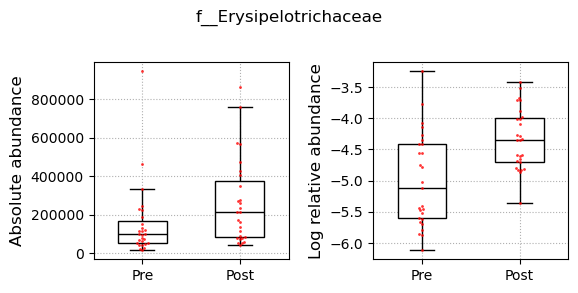

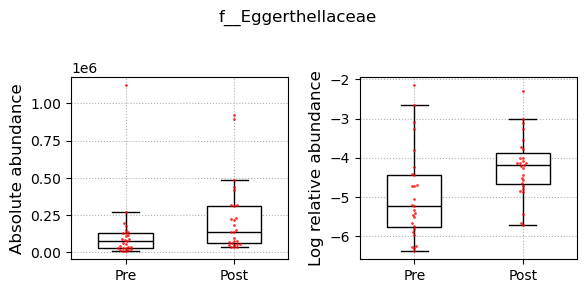

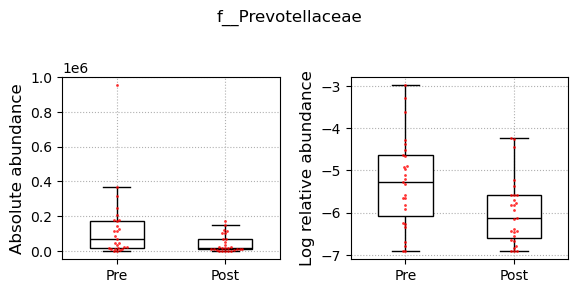

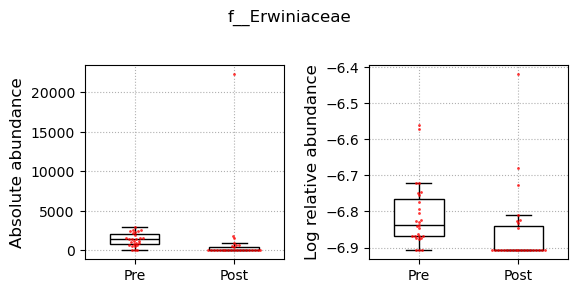

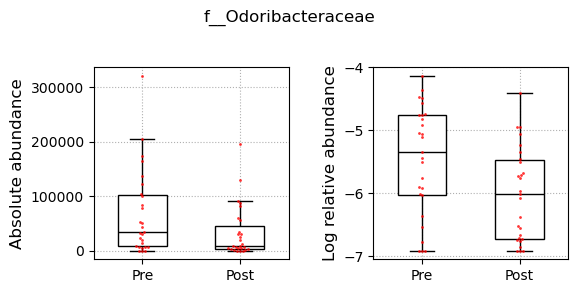

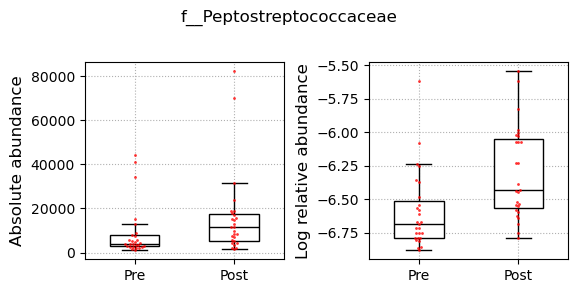

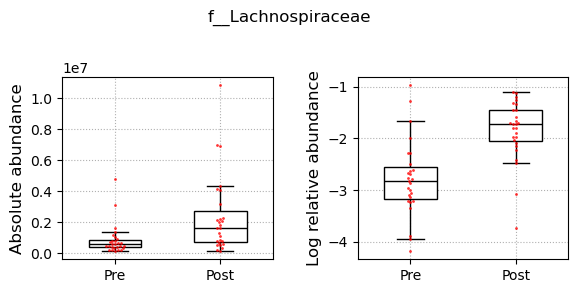

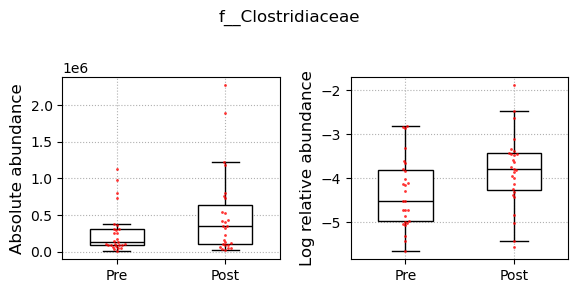

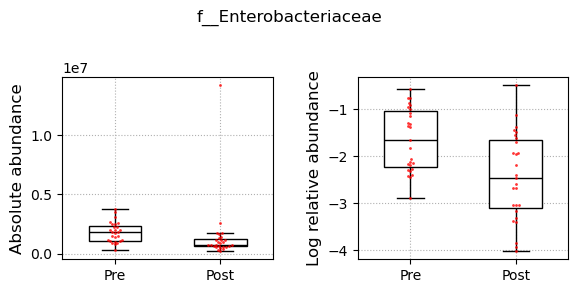

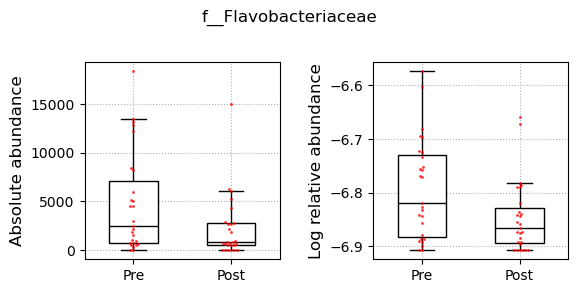

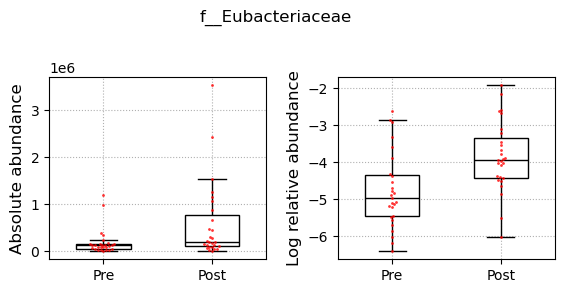

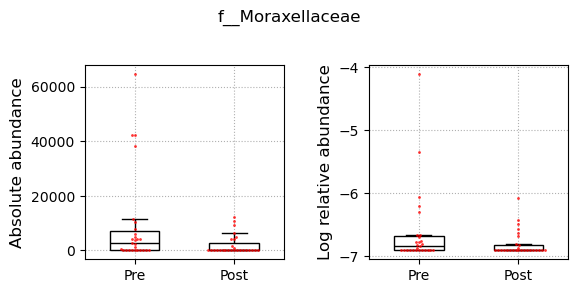

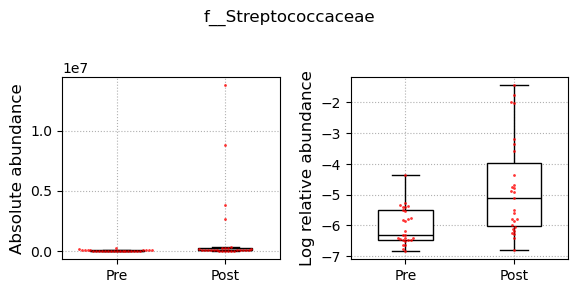

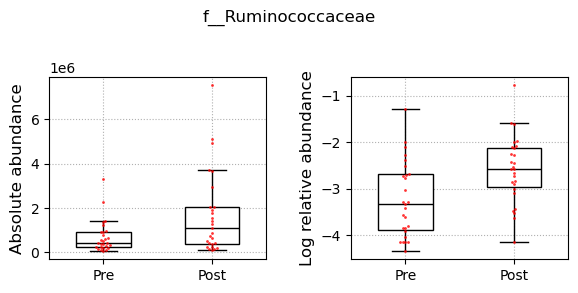

In [10]:
for family in intersection:
    plot_family_boxplots(absolute_stacked, family, relative_stacked)

## Pvalues correlation

This code visualizes the comparison between absolute and relative p-values for different families in a scatter plot and prints Spearman correlation between pvalues

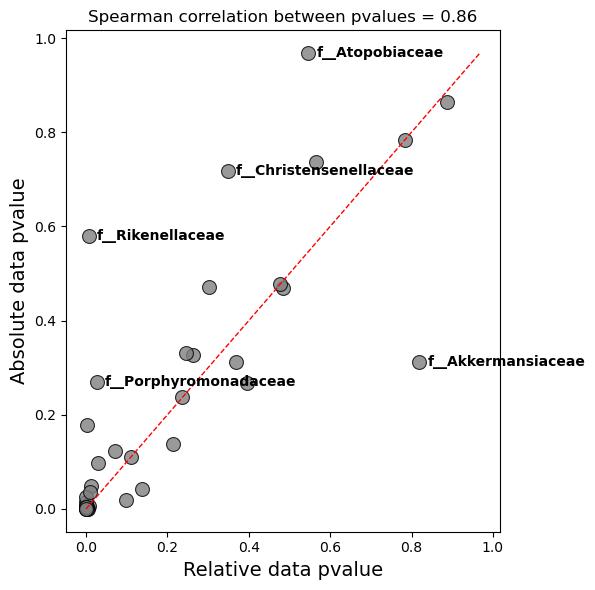

In [11]:
# Merging the absolute and relative p-value results
pvalues_df = pd.concat([absolute_wilcoxon_results.rename({"pvalue":"pvalue_abs"}, axis=1).set_index('family'), 
                       relative_wilcoxon_results.rename({"pvalue":"pvalue_rel"}, axis=1).set_index('family')], 
                      axis=1).dropna()

t_stat, p_value = stats.ttest_ind(pvalues_df.pvalue_abs, pvalues_df.pvalue_rel, equal_var=False)
correlation, corr_p_value = stats.spearmanr(pvalues_df.pvalue_abs, pvalues_df.pvalue_rel)


# Calculating the absolute difference between the p-values
pvalues_df['difference'] = np.abs(pvalues_df['pvalue_abs'] - pvalues_df.pvalue_rel)

# Identifying the families with the largest difference
plot_txt = pvalues_df.sort_values(by = ['difference']).tail(5).index

# Create the scatter plot
plt.figure(figsize = (6, 6))
sns.scatterplot(x = pvalues_df.pvalue_rel, y = pvalues_df.pvalue_abs, s = 100, edgecolor = 'k', color='grey', alpha = .8)
#plt.grid(linestyle=':')

# Annotating families with the largest p-value differences
for i in range(len(pvalues_df)):
    family_name = pvalues_df.index[i]  # Family name (from index)
    if family_name in plot_txt:
        plt.text(pvalues_df.pvalue_rel[i] + 0.02,  # Shift text slightly to the right
                 pvalues_df.pvalue_abs[i], 
                 family_name, 
                 horizontalalignment='left',  # Align text to the left
                 verticalalignment='center', 
                 fontsize=10, color='k', fontweight='bold')

plt.title(f'Spearman correlation between pvalues = {correlation:.2f}')

# Add a diagonal line
min_val = min(pvalues_df.pvalue_rel.min(), pvalues_df.pvalue_abs.min())
max_val = max(pvalues_df.pvalue_rel.max(), pvalues_df.pvalue_abs.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1)

plt.xlabel('Relative data pvalue', fontsize=14)
plt.ylabel('Absolute data pvalue', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

In [14]:
print(f'ttest pvalue = {p_value:.2f}, means that the difference in pvalues is not significant')

ttest pvalue = 0.52, means that the difference in pvalues is not significant
